# Классификация заемщиков линейными моделями

## курс "Машинное обучение 1", программа AIMasters, 2024

## Студент: Шеряев Антон Владимирович

## Реализация алгоритмов (5 баллов)

Ниже нужно написать собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит тесты. В этом блоке можно использовать только `numpy, scipy`.


В `BinaryLogisticLoss` вам нужно реализовать расчет лосса и его градиента для функции 
$$L(w) = \frac{1}{N} \sum_{N} [\log(1 + \exp(-y_i\langle w, x_i\rangle))] + \lambda \lVert w \rVert^2_2, \quad y \in \{-1, 1\}$$

- `func(self, X, y, w)` — вычисление значения функции потерь на матрице признаков X, векторе ответов y с вектором весов w.
- `grad(self, X, y, w)` — вычисление значения градиента функции потерь на матрице признаков X, векторе ответов y с вектором весов w.

У обоих методов одинаковые аргументы:
- X - выборка объектов
- y - вектор ответов
- w - вектор коэффициентов модели

Вектор коэффициентов имеет вид: w = `[bias, weights]`, то есть нулевой элемент w - `bias`, остальное - веса, участвующие в скалярном произведении. **Важно:** `bias` не участвует в расчете слагаемого с $\lambda$.

Обратите внимание, что на матрица X на входе без столбца с 1 в начале. Пример изменения Х внутри кода функций:
```python
X_new = np.c_[np.ones(X.shape[0]), X]
```

In [1]:
import numpy as np
import scipy
from scipy.special import expit


class BinaryLogisticLoss:
    """
    Loss function for binary logistic regression.
    It should support l2 regularization.
    """

    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        """
        Get loss function value for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        X_new = np.c_[np.ones(X.shape[0]), X]
        return (
            np.mean(np.logaddexp(0, -y[:, None] * X_new @ w))
            + self.l2_coef * (np.linalg.norm(w[1:], 2)) ** 2
        )

    def grad(self, X, y, w):
        """
        Get loss function gradient for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : 1d numpy.ndarray
        """
        X_new = np.c_[np.ones(X.shape[0]), X]

        w_no_bias = w.copy()
        w_no_bias[0] = 0

        return (
            -(expit(-y[:, None] * X_new @ w) * y) @ X_new / X.shape[0]
            + 2 * self.l2_coef * w_no_bias
        )

In [2]:
loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
assert np.isclose(loss_function.func(X, y, w), 16.00008, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 5],
    [-10 ** 5],
    [10 ** 5]
])
y = np.array([1, -1, 1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 0, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 2],
    [-10 ** 2],
    [10 ** 2]
])
y = np.array([-1, 1, -1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 10000.333334, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
right_gradient = np.array([0.33325, 4.3335 , 6.66634])
assert np.isclose(loss_function.grad(X, y, w), right_gradient, atol=1e-5).all()

В `LinearModel` нужно реализовать линейную модель, поддерживающей обучение через стохастический градиентные спуск.

`__init__` — инициализатор класса с параметрами:
- loss_function — функция потерь, заданная классом
- batch_size — размер подвыборки, по которой считается градиент
- step_alpha — параметр шага градиентного спуска 
- tolerance — критерий останова метода — модуль разности значений функции потерь на соседних итерациях метода меньше tolerance, не весов.
- max_iter — максимальное число итераций (эпох)

`fit(self, X, y, w_0=None)` — обучение линейной модели

- X — выборка объектов
- y — вектор ответов
- w_0 — начальное приближение вектора коэффициентов, если None, то необходимо инициализировать внутри метода. w_0 имеет вид `[bias_0, weights_0]`.

`predict_proba(self, X)` — получение вероятностей для 2х классов
- X — выборка объектов

Вы можете поменять формат изменения шага градиентного спуска, по дефолту предполагается, что можно использовать просто `step_alpha`.

Про sgd: нет необходимости проводить честное семплирование для каждого батча в методе стохастического градиентного спуска. Вместо этого предлагается в начале одной эпохи сгенерировать случайную перестановку индексов объектов, а затем последовательно выбирать объекты для нового батча из элементов этой перестановки. Псевдокод:
```python
epoch_rand_indexes = np.random.permutation(X.shape[0])
inner_cycle_length = int(np.ceil(X.shape[0] / self.batch_size))

for i in range(inner_cycle_length):
    start_index = self.batch_size * i
    finish_index = self.batch_size * (i + 1)
    batch_indexes = epoch_rand_indexes[start_index:finish_index]
    # тут считаем градиент только по batch_indexes
```

Еще несколько советов:

В промежуточных вычислениях стоит избегать вычисления $\exp(−y_i⟨x_i,w⟩)$, иначе может произойти переполнение.
Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp, scipy.special.logsumexp и scipy.special.expit`. В ситуации, когда вычисления экспоненты обойти не удаётся, можно воспользоваться процедурой «клипинга» (функция `numpy.clip`).


In [3]:
import numpy as np
from scipy.special import expit
from tqdm.notebook import tqdm

class LinearModel:
    def __init__(
        self,
        loss_function,
        batch_size=100,
        step_alpha=1,
        tolerance=1e-5,
        max_iter=1000,
        random_seed=0,
        **kwargs
    ):
        """
        Parameters
        ----------
        loss_function : BaseLoss inherited instance
            Loss function to use
        batch_size : int
        step_alpha : float
        tolerance : float
            Tolerace for stop criterio.
        max_iter : int
            Max amount of epoches in method.
        """
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        
        np.random.seed(random_seed)

        self.w = None


    def fit(self, X, y, w_0=None):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, training set.
        y : numpy.ndarray
            1d vector, target values.
        w_0 : numpy.ndarray
            1d vector in binary classification.
            Initial approximation for SGD method - [bias, weights]
        """
            
        if w_0 is None:
            w_k = np.zeros(X.shape[1] + 1) # [bias, weights]
        else:
            w_k = w_0

        self.w = w_k

        loss_history = [loss_function.func(X, y, w_k)]

        for i in tqdm(range(self.max_iter)):
            epoch_rand_indexes = np.random.permutation(X.shape[0])
            inner_cycle_length = int(np.ceil(X.shape[0] / self.batch_size))

            for i in range(inner_cycle_length):
                start_index = self.batch_size * i
                finish_index = self.batch_size * (i + 1)
                batch_indexes = epoch_rand_indexes[start_index:finish_index]

            grad = loss_function.grad(X[batch_indexes], y[batch_indexes], self.w)
            self.w -= self.step_alpha * grad 
            loss_history.append(loss_function.func(X, y, self.w))
            if np.abs(loss_history[-1] - loss_history[-2]) < self.tolerance:
                break


    def predict_proba(self, X):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, test set.
        Returns
        -------
        : numpy.ndarray
            probs, shape=(X.shape[0], 2)
        """
        X_new = np.c_[np.ones(X.shape[0]), X]
        probs = expit(X_new @ self.w)
        return np.c_[1 - probs, probs]

In [4]:
# обратите внимание, что тут достаточно простой тест
# ниже еще есть проверка для данных из data
X1 = np.random.randint(1, 4, (1000, 10))
X2 = np.random.randint(-4, 0, (1000, 10))
X = np.vstack((X1, X2))
y = np.array([-1] * 1000 + [1] * 1000)
loss_function = BinaryLogisticLoss(l2_coef=0.1)
linear_model = LinearModel(
    loss_function=loss_function,
    batch_size=100,
    step_alpha=1,
    tolerance=1e-4,
    max_iter=1000,
)
linear_model.fit(X, y)
prediction_probs = linear_model.predict_proba(X)
predictions = (prediction_probs > 0.5).astype('int')[:, 1] * 2 - 1
assert np.isclose(predictions, y).all()

  0%|          | 0/1000 [00:00<?, ?it/s]

## Эксперименты (5 баллов)

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). Для экспериментов будем использовать лишь основной файл `application_train.csv`, а также перекодируем таргет в метки -1, 1.

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение и тест.

Код в чтение, разбиение и предобработке менять не нужно.

Выполняя задания, не забывайте про [устав](https://t.me/c/2206639786/270/271).

In [5]:
# не меняем код
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150


data = pd.read_csv('application_train.csv')
data.columns = [
    '_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns
]
data.target = data.target.map({0: -1, 1: 1})
data.head(3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


In [7]:
# не меняем код
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

X_tr, X_tst = data_dict["tr"][features].to_numpy(), data_dict["tst"][features].to_numpy()
y_tr, y_tst = data_dict["tr"]["target"].to_numpy(), data_dict["tst"]["target"].to_numpy()


prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

prep.fit(X_tr)

X_tr = prep.transform(X_tr)
X_tst = prep.transform(X_tst)

Инициализируйте написанный выше лосс и классификатор, для `BinaryLogisticLoss` возьмите параметр `l2_coef=0.1`, параметры `LinearModel` нужно подобрать так, чтобы [roc_auc_score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html) был больше 0.72.

In [8]:
loss_function = BinaryLogisticLoss(l2_coef=0.1)
clf = LinearModel(
    loss_function,
    step_alpha=1e-2
)

In [9]:
clf.fit(X_tr, y_tr)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
from sklearn.metrics import roc_auc_score

assert roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1]) > 0.72

Ура! Ваша модель что-то может :)

Теперь нужно поисследовать реализацию [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) в sklearn.

Сравните различные `solver` по времени обучения/качеству на тесте. Напишите выводы.

Выбейте на тесте больше `0.737` roc_auc_score.
Для поиска лучшей модели можно использовать:
- optuna
- [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
- свои наблюдения и интуицию


In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    penalty='l2',
    tol=1e-5,
    max_iter=500,
    C=10
)

In [12]:
clf.fit(X_tr, y_tr)

LogisticRegression(C=10, max_iter=500, tol=1e-05)

In [13]:
assert roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1]) > 0.737

Теперь сравним различные `solver` по времени обучения/качеству на тесте.

In [14]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from time import time

solvers = [
    'lbfgs', 'liblinear', 'newton-cg', 
    'newton-cholesky', 'sag', 'saga'
]

train_time, test_score = [], []

for solver in solvers:
    
    clf_ = LogisticRegression(
        penalty='l2',
        tol=1e-5,
        max_iter=500,
        C=10,
        solver=solver
    )
    
    start_time = time()
    clf_.fit(X_tr, y_tr)
    end_time = time()
    train_time.append(end_time - start_time)
    test_score.append(roc_auc_score(y_tst, clf_.predict_proba(X_tst)[:, 1]))

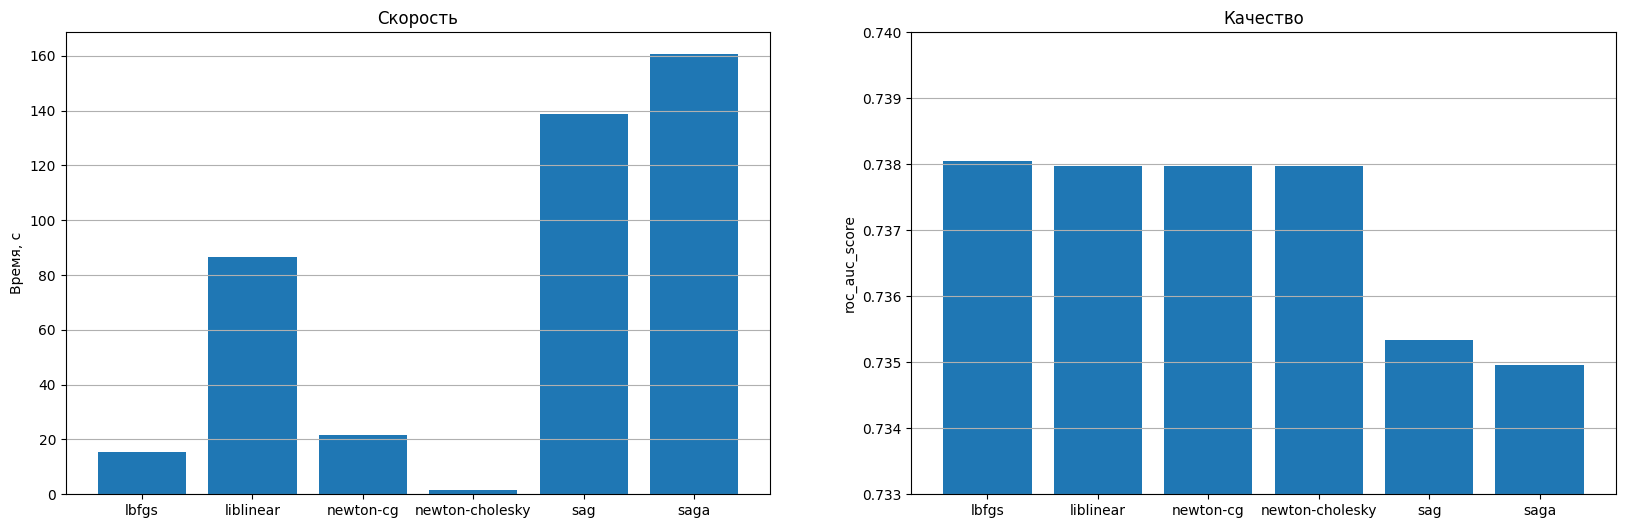

In [18]:
fig, ax = plt.subplots(1, 2)

ax[0].bar(solvers, train_time)
ax[0].set_title('Скорость')
ax[0].grid(True, axis="y")
ax[0].set_ylabel('Время, с')

ax[1].bar(solvers, test_score)
ax[1].set_title('Качество')
ax[1].set_ylim(0.733, 0.74)
ax[1].grid(True, axis="y")
ax[1].set_ylabel('roc_auc_score')

fig.set_size_inches(20, 6)
plt.show()

Вывод: 
- самые быстрые солверы: `newton-cholesky`, `lbfgs` и `newton-cg`; самый медленные - `sag` и `saga`;
- худшее качество выдали солверы `saga` и `sag`; лучшее - `lbfgs`.

Нарисуйте график `feature - weight`, показывающий `top_k` (на ваш выбор) признаков по модулю веса и их значения весов. <br>
Признаки должны идти по убыванию модуля веса. <br>
Лучше использовать [barplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) или аналоги из других библиотек. <br>
Опишите наблюдения, используя описания признаков в `description.csv`.

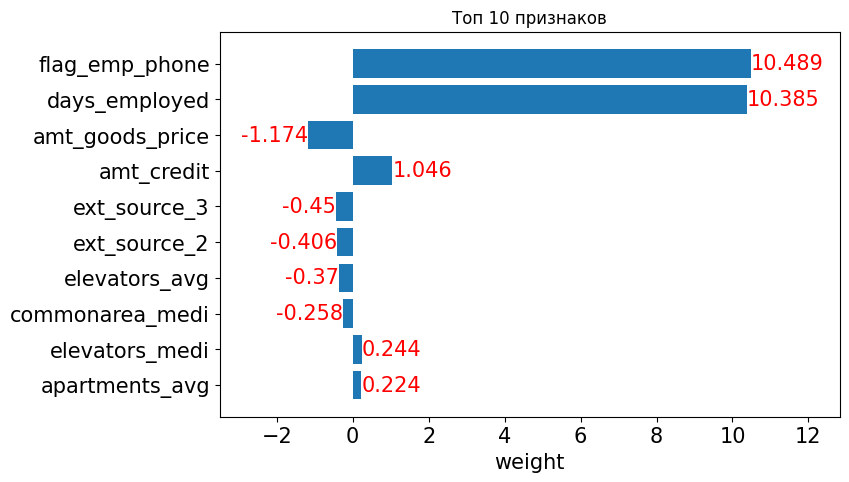

In [16]:
# ваш график
fig, ax = plt.subplots(figsize=(8, 5))
top_k = 10
weights = clf.coef_[0]
sorted_idx = np.argsort(-np.abs(weights))

container = ax.barh(y=features[sorted_idx][:top_k][::-1], width=weights[sorted_idx][:top_k][::-1])
ax.bar_label(container, weights[sorted_idx][:top_k][::-1].round(3), color='red', fontsize=15)
ax.margins(0.2, 0.05)
ax.set_title(f'Топ {top_k} признаков')
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('weight', fontsize=15)

plt.show()

Значительный отрыв по весу имеют признаки `flag_emp_phone` и `days_employed`.

Выведите топ признаков с наибольшим/наименьшим абсолютным весом.<br>
Опишите наблюдения (ответьте на вопрос: правда ли, что если признак `X` больше/меньше, то вероятность дефолта клиента выше/ниже?).

In [17]:
# вывод топ фичей с описаниями
description = pd.read_csv('description.csv')

print(f'Описания {top_k} признаков с наибольшим абсолютным весом:')
for feature in features[sorted_idx][:top_k]:
    print(feature, ':', description[description['Row'] == feature.upper()]['Description'].values)

print('#'*100)

print(f'Описания {top_k} признаков с наименьшим абсолютным весом:')
for feature in features[sorted_idx][-top_k:]:
    print(feature, ':', description[description['Row'] == feature.upper()]['Description'].values)

Описания 10 признаков с наибольшим абсолютным весом:
flag_emp_phone : ['Did client provide work phone (1=YES, 0=NO)']
days_employed : ['How many days before the application the person started current employment']
amt_goods_price : ['For consumer loans it is the price of the goods for which the loan is given'
 'Goods price of good that client asked for (if applicable) on the previous application']
amt_credit : ['Credit amount of the loan'
 'Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT']
ext_source_3 : ['Normalized score from external data source']
ext_source_2 : ['Normalized score from external data source']
elevators_avg : ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size,

Интерпретация топ 10 признаков с наибольшим по модулю весом
* `flag_emp_phone`: клиент, указывающий рабочий телефон, более надёжный, поэтому факт наличия рабочего телефона повышает вероятность погашения кредита;
* `days_employed`: если клиент долго работает на текущем месте, то это скорее всего значит, что работа стабильная и у клиента есть достаточная финансовая подушка безопасности для погашения кредита, поэтому если значение этого признака выше, то вероятность погашения кредита также выше;
* `amt_goods_price`, `amt_credit`: довольно странно, что эти признаки имеют разные знаки. На мой взгляд, чем выше сумма кредита, тем сложнее его погасить, а значит вероятность дефолта больше;
* `ext_source_3`, `ext_source_2`: интерпретация данных признаков зависит от того, в каком виде приведены данные из внешних источников, поэтому трудно сказать, как они влияют на вероятность погашения кредита.
* `commonarea_medi`, `elevators_medi`, `apartments_avg`: с одной стороны, характеристики дома, в котором живёт клиент, могут говорить о "классе" дома и о том, насколько клиент состоятелен и, следовательно, с какой вероятностью он погасит кредит, но с другой стороны это косвенный признак; к тому же, признаки `basementarea_mode`, `entrances_mode`, `floorsmin_avg`, `floorsmin_mode`, `years_build_mode`, которые также характеризуют дом клиента, присутствуют в списке признаков с наименьшими по модулю весами, поэтому склоняюсь к тому, что на самом деле все эти признаки мало влияют на вероятность погашения кредита.

Интерпретация топ 10 признаков с наименьшим по модулю весом
* `flag_cont_mobile`: я считаю, что этот признак действительно не влияет на вероятность дефолта клиента, поскольку ответит клиент на звонок или нет скорее зависит от того, насколько занят был клиент в момент звонка и какая была мобильная связь;
* `flag_document_20`, `flag_document_21`, `flag_document_7`: ответ зависит от того, какие документы скрываются под этими номерами и какие требования к документам у банка;
* `amt_req_credit_bureau_hour`: лог регрессия посчитала данный признак незначимым, но большое количество обращений в кредитное бюро по идее ухудшает кредитную историю, поэтому большее значение данного признака соответствует большей вероятности дефолта.